<a href="https://colab.research.google.com/github/rzunick/MNA-Proyecto-Integrador-Equipo-43/blob/main/Avance_5_v3_Transfer_Learning_Equipo_43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Introduction

In this notebook, an additional model is explored for the Dominant Color Detection Project. The additional model is the VGG16 network enhanced through transfer learning to make use of the pre-trained abstractions in the first and middle layers.

Transfer learning turns out to be useful when dealing with relatively small datasets; for examples medical images, which are harder to obtain in large numbers than other datasets. Instead of training a deep neural network from scratch, which would require a significant amount of data, power and time, it's often convenient to use a pretrained model and just finetune its performance to simplify and speed up the process.

Convolutional networks are used on (but not only) images instead of fully-connected feedforward networks because they would require a very high number of neurons - i.e. at least one per pixel in the input layer - and that would make them inconvenient

#2 - Importando el Dataset

In [1]:
import torch
import torch.nn as nn
import os
import  numpy as np
import pandas as pd
from torch.utils.data import  Dataset, DataLoader
from  PIL import  Image
from  torchvision.transforms import  ToTensor, Compose, Resize, CenterCrop, Normalize
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import  glob
import requests
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
import shutil
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F

!pip install opencv-python-headless
from torchsummary import summary

from PIL import Image
import cv2
from collections import Counter

from  tqdm import tqdm
from sklearn.metrics import accuracy_score

from  collections import  defaultdict
import json

import time
import random

import torchvision
from torchvision import models, transforms

In [2]:
# URL of the .zip file in the GitHub repository
github_zip_url = "https://github.com/rzunick/MNA-Proyecto-Integrador-Equipo-43/raw/main/cifar_10_color_v4_balanced.zip?download="

# Path to save the downloaded .zip file
zip_file_path = '/content/cifar_10_color_v4.zip'

# Download the .zip file from GitHub
response = requests.get(github_zip_url)
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Verify the download
if response.status_code == 200:
    print("File downloaded successfully")
else:
    print("Failed to download file")

File downloaded successfully


In [3]:
#Specify zip file path
zip_file_path = '/content/cifar_10_color_v4.zip'

In [4]:
# Confirmar tipo de archivo es tipo .zip
!file /content/cifar_10_color.zip

/content/cifar_10_color.zip: cannot open `/content/cifar_10_color.zip' (No such file or directory)


In [5]:
from zipfile import ZipFile

# Specify the directory where you want to extract the files
extract_to_directory = '/content'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)

In [6]:
# Dataset Path
path = '/content/cifar_10_color_v4'

Label counts: Counter({2: 1600, 6: 1600, 0: 1600, 3: 1600, 4: 1600, 1: 1600, 5: 1600, 7: 1600})


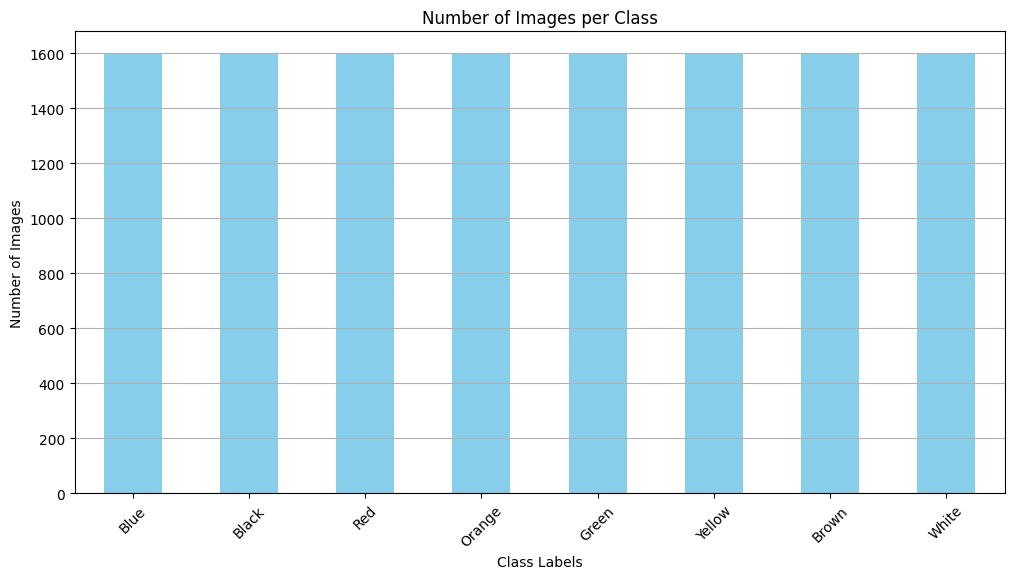

In [7]:
# Configuration 4: 8 labels
labels = ["Red","Yellow","Blue","Orange","Green","Brown","Black","White"]

def decode_label(index):
    return  labels[index]

def encode_label_from_path(path):
    for index,value in enumerate(labels):
        if value in path:
            return  index

# Get image list
image_list = glob.glob(os.path.join(path, '**', '*.*'), recursive=True)
class_list = [encode_label_from_path(item) for item in image_list]

# Count the number of images per class
from collections import Counter
label_counts = Counter(class_list)
print("Label counts:", label_counts)

# Convert the counter to a pandas DataFrame
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
label_df.index = [labels[idx] for idx in label_df.index]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
label_df['count'].plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

## Dataset Normalization and Dataloader

70 Training / 15 Validation / 15 Test

In [8]:
# Train and Test subsets
x_train, x_temp, y_train, y_temp = train_test_split(image_list, class_list, train_size= 0.7 , stratify=class_list , shuffle=True, random_state=42)

# Dividing Training dataset into Train and Validation subsets
# Since x_temp and y_temp are 30% of the original, splitting them in half gives each 15% of the original dataset.
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42)

In [9]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit VGG16 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class CIFAR10ColorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data into PyTorch Datasets
train_dataset = CIFAR10ColorDataset(x_train, y_train, transform=transform)
val_dataset = CIFAR10ColorDataset(x_val, y_val, transform=transform)
test_dataset = CIFAR10ColorDataset(x_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#3 - Transfer Learning to VGG16

In [10]:
# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all layers in the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 8)  # 8 outputs for your color categories

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]


In [14]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Print the summary of the model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Training

In [26]:
# Define the base path for saving model checkpoints
base_path = '/content/model_checkpoints'
if not os.path.exists(base_path):
    os.makedirs(base_path)  # Creates the directory if it doesn't exist

In [27]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, save_path=base_path):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append((train_corrects.double() / len(train_loader.dataset)).cpu().tolist())

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append((val_corrects.double() / len(val_loader.dataset)).cpu().tolist())

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.4f} Val Loss: {val_losses[-1]:.4f} Acc: {val_accuracies[-1]:.4f}')

        # Save the model weights for each epoch
        model_save_path = os.path.join(save_path, f'model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [28]:
# Call the training function
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10 - Train Loss: 0.0084 Acc: 0.9984 Val Loss: 1.8416 Acc: 0.6495
Model saved to /content/model_checkpoints/model_epoch_1.pt
Epoch 2/10 - Train Loss: 0.0097 Acc: 0.9979 Val Loss: 1.8510 Acc: 0.6458
Model saved to /content/model_checkpoints/model_epoch_2.pt
Epoch 3/10 - Train Loss: 0.0076 Acc: 0.9992 Val Loss: 1.8717 Acc: 0.6562
Model saved to /content/model_checkpoints/model_epoch_3.pt
Epoch 4/10 - Train Loss: 0.0078 Acc: 0.9984 Val Loss: 1.8561 Acc: 0.6495
Model saved to /content/model_checkpoints/model_epoch_4.pt
Epoch 5/10 - Train Loss: 0.0067 Acc: 0.9991 Val Loss: 1.8686 Acc: 0.6422
Model saved to /content/model_checkpoints/model_epoch_5.pt
Epoch 6/10 - Train Loss: 0.0062 Acc: 0.9989 Val Loss: 1.9219 Acc: 0.6438
Model saved to /content/model_checkpoints/model_epoch_6.pt
Epoch 7/10 - Train Loss: 0.0062 Acc: 0.9992 Val Loss: 1.9022 Acc: 0.6490
Model saved to /content/model_checkpoints/model_epoch_7.pt
Epoch 8/10 - Train Loss: 0.0058 Acc: 0.9991 Val Loss: 1.9439 Acc: 0.6443
Mod

Performance Metrics

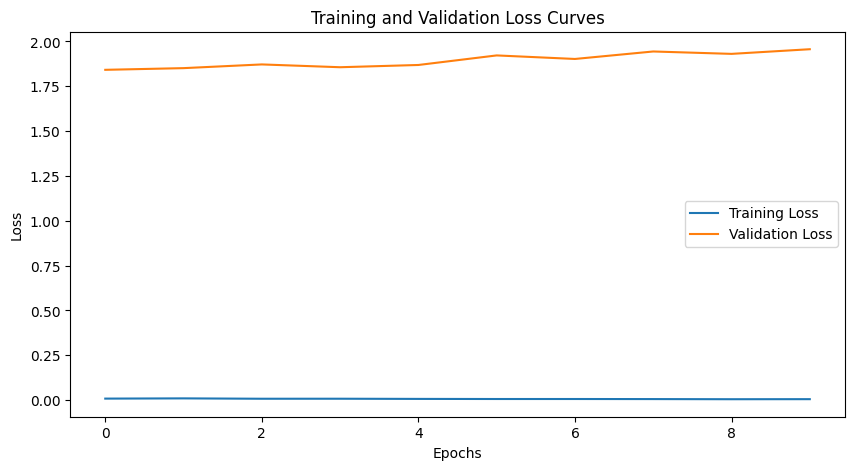

In [29]:
# Training and Validation Loss
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

# Plot the loss curves
plot_loss_curves(train_losses, val_losses)

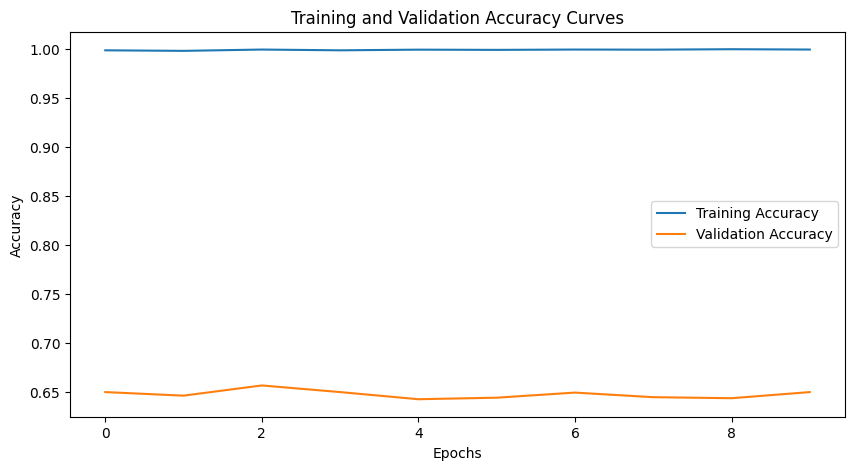

In [30]:
# Training and validation accuracy
def plot_accuracy_curves(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

# Plot the accuracy curves
plot_accuracy_curves(train_accuracies, val_accuracies)

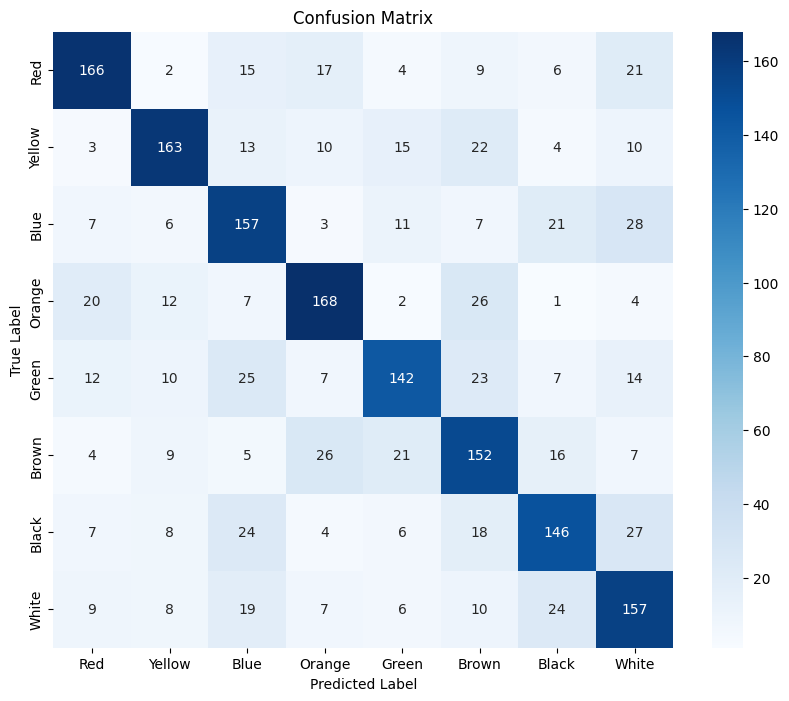

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage (assuming y_test contains true labels)
y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

# Plot Confusion Matrix for Test Dataset
plot_confusion_matrix(y_true, y_pred, labels)

Test Loss and Accuracy

In [32]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track the gradients
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    avg_test_loss = test_loss / total_predictions
    test_accuracy = correct_predictions / total_predictions * 100  # Convert to percentage

    return avg_test_loss, test_accuracy

In [33]:
criterion = nn.CrossEntropyLoss()  # Define the same criterion used in training if not already defined
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 2.0398
Test Accuracy: 65.16%


Model Profiling

In [52]:
import torch
from torchvision import models
from torch.profiler import profile, record_function, ProfilerActivity

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize and load the VGG16 model
model.load_state_dict(torch.load('/content/model_checkpoints/model_epoch_10.pt'))  # Update the path to where your model weights are stored
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [56]:
def profile_model(model, data_loader, device):
    with torch.no_grad():
        # Grab one batch of data
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            break

    # Using profiler to analyze execution time and memory
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                 profile_memory=True,
                 record_shapes=True) as prof:
        with record_function("model_inference"):
            model(inputs)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
    print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))

# Run profiling
print("Profiling VGG16 Model")
profile_model(model, test_loader, device)

Profiling VGG16 Model
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us      74.053ms        50.05%      74.053ms      74.053ms           0 b           0 b     

#4 - Model Results

In [35]:
# Load the weights
model_weights_path = '/content/model_checkpoints/model_epoch_10.pt'

# Load the model weights
model.load_state_dict(torch.load(model_weights_path))

# Set the model to evaluation mode
model.eval()

# Check device and send model to device if using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


Top 3 Predicted Labels with Confidence Percentages:
1: Label = Blue, Confidence = 76.83%
2: Label = White, Confidence = 23.13%
3: Label = Red, Confidence = 0.02%


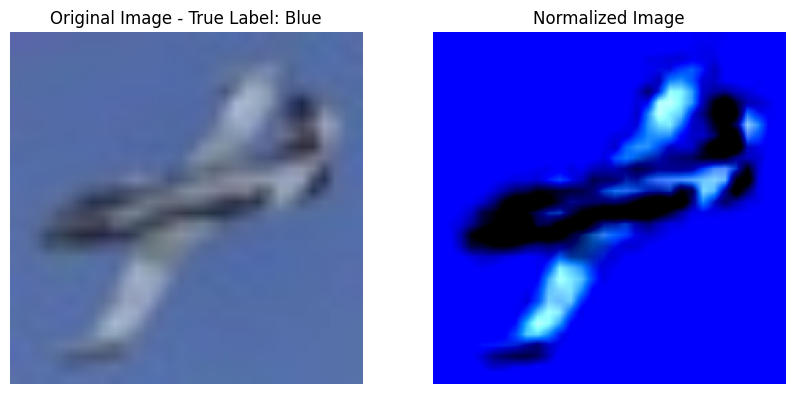

In [57]:
# Randomly pick an image from the test dataset
random_index = random.randint(0, len(test_loader.dataset) - 1)
image, label = test_loader.dataset[random_index]

# Function to denormalize the image
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.permute(1, 2, 0).numpy()  # Change CxHxW to HxWxC
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# Prepare the image for inference
image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

# Run the model to get the output logits
with torch.no_grad():
    output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    top3_prob, top3_labels = torch.topk(probabilities, 3)

# Convert probabilities and labels to CPU for displaying
top3_prob = top3_prob.cpu().numpy().flatten()
top3_labels = top3_labels.cpu().numpy().flatten()

# Visualize the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the denormalized image
image_display = denormalize(image)
axs[0].imshow(image_display)
axs[0].set_title(f'Original Image - True Label: {labels[label]}')
axs[0].axis('off')

# Display the normalized image (for visualization)
# Note: Directly displaying normalized images might not be visually meaningful
axs[1].imshow(image.permute(1, 2, 0).numpy())  # Change CxHxW to HxWxC for matplotlib
axs[1].set_title('Normalized Image')
axs[1].axis('off')

# Print the predicted labels with confidence percentages
print("Top 3 Predicted Labels with Confidence Percentages:")
for i, idx in enumerate(top3_labels):
    print(f"{i+1}: Label = {labels[idx]}, Confidence = {top3_prob[i]*100:.2f}%")

#6 - Conclusions

**Model Overview:**

1. Large Model: Your model has a substantial number of parameters (over 134 million), with nearly 120 million trainable. This suggests a complex model capable of learning detailed features but also prone to overfitting, especially on smaller datasets.
2. Resource Intensive: The considerable size of the model also means that it's computationally expensive, as indicated by the significant memory requirements during training.


**Training and Validation Performance:**
1. Overfitting Indication: The training loss is very low and the training accuracy is nearly perfect. In contrast, the validation loss is much higher and does not decrease over epochs, while the validation accuracy is significantly lower and does not improve. This is a classic sign of overfitting, where the model learns to perform exceptionally well on the training data but fails to generalize effectively on unseen data.

2. Validation Loss Increases: There is an upward trend in the validation loss as training progresses, further supporting the overfitting diagnosis.


**Confusion Matrix Analysis:**
1. Misclassifications: The confusion matrix shows a relatively good diagonal spread (which indicates correct classifications), but there are noticeable misclassifications between several classes. This could be due to similarities in the color shades or possibly errors in labeling or data quality.

2. Class Performance: Some colors like "Red" and "White" have higher false positives and false negatives, suggesting that the model may struggle with these due to possible reasons like under-representation in the training data or inherent difficulty in distinguishing these colors from others.

**Suggestions for Improvement:**
1. Data Augmentation: Implementing or increasing data augmentation can help the model generalize better and reduce overfitting. Techniques like rotation, scaling, and color jittering can be beneficial.

2. Regularization Techniques: Employ regularization methods such as dropout or L2 regularization to help mitigate overfitting.

3. Model Simplification: Considering reducing the model's complexity by decreasing the number of layers or parameters, which might help in reducing the overfitting.

4. Hyperparameter Tuning: Experiment with different learning rates, batch sizes, or other optimizer settings to find a better fit for the model.

5. Advanced Techniques: Techniques like transfer learning from a similar task or employing different architectures (like ResNets or Inception networks) might yield better results.

6. Reevaluate Dataset: Check the balance and distribution of the dataset. Ensuring each class is equally represented and the data quality is high can significantly impact model performance.

#7 - References

1. Smits, Thomas & Wevers, Melvin. (2021). The agency of computer vision models as optical instruments. Visual Communication. 21. 147035722199209. 10.1177/1470357221992097.

2. Top 10 Datasets for Computer Vision · Syntric AI. (2022). Retrieved from https://www.syntric.ai/post/unlocking-computer-vision-the-10-best-datasets

3. Common Objects in Context. (n.d.). Retrieved from https://cocodataset.org/#home

4. Meel, V. (2024). What is the COCO Dataset? What you need to know in 2024. Retrieved from https://viso.ai/computer-vision/coco-dataset/

5. Maitlo, N., Noonari, N., Ghanghro, S. A., Duraisamy, S., & Ahmed, F. (2024). Color Recognition in Challenging Lighting Environments: CNN Approach. ArXiv. /abs/2402.04762

6. De, K., & Pedersen, M. (2021). Impact of Colour on Robustness of Deep Neural Networks. 2021 IEEE/CVF International Conference on Computer Vision Workshops (ICCVW), 21–30. https://doi.org/10.1109/ICCVW54120.2021.00009

7. FiftyOne by Voxel 51. (n.d.). Retrieved from https://docs.voxel51.com/

8. COCO Dataset Integration in Fifty One. (n.d.). Retrieved from https://docs.voxel51.com/integrations/coco.html?highlight=coco

9. Hofesmann, E. (2022). The COCO Dataset: Best Practices for Downloading, Visualization, and Evaluation. Retrieved from https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

10. Clustering Images with Embeddings. (n.d.). Retrieved from https://docs.voxel51.com/tutorials/clustering.html

11. Gallagher, J. (2024). Color and Product Type Inspection with Computer Vision. Retrieved from https://blog.roboflow.com/how-to-analyze-product-color/

12. Lin, T.-Y., Maire, M., Belongie, S., Bourdev, L., Girshick, R., Hays, J., … Dollár, P. (2015). Microsoft COCO: Common Objects in Context. Retrieved from https://arxiv.org/abs/1405.0312

13. Rachmadi, R. F., & Purnama, I. K. E. (2018). Vehicle Color Recognition using Convolutional Neural Network. Retrieved from https://arxiv.org/abs/1510.07391

14. Hofesmann, E. (2021). How to work with object detection datasets in COCO format. Retrieved from https://towardsdatascience.com/how-to-work-with-object-detection-datasets-in-coco-format-9bf4fb5848a4

15. Prepare COCO datasets¶. (n.d.). Retrieved from https://cv.gluon.ai/build/examples_datasets/mscoco.html

16. skimage.color#. (n.d.). Retrieved from https://scikit-image.org/docs/dev/api/skimage.color.html

17. Colors Tutorial. W3 Schools. (N.d.). Retrieved from https://www.w3schools.com/colors/colors_wheels.asp#:~:text=The%203%20primary%20colors%20are,Orange%2C%20Green%2C%20and%20Purple.&text=Blue%20and%20Red%20%3D%20Purple.